In [1]:
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt


In [2]:
class Individual:
    """ Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de NUM_ITEMS elementos (genes),
       cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la mochila el item i del pool) """

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 

    def mutation_flip(self):
        "Cambia aleatoriamente el alelo de un gen."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            new_chromosome[mutGene] = 1
        else:
            new_chromosome[mutGene] = 0
        return Individual(new_chromosome)


In [3]:
def create_reference_solutions(chromosome_length, solutions):
    """
    Function to create reference chromosomes that will mimic an ideal solution 
    """
    references = np.zeros((solutions, chromosome_length))
    number_of_ones = int(chromosome_length / 2)
    
    for solution in range(solutions):
        # Build an array with an equal mix of zero and ones
        reference = np.zeros(chromosome_length)
        reference[0: number_of_ones] = 1
    
        # Shuffle the array to mix the zeros and ones
        np.random.shuffle(reference)
        references[solution,:] = reference
    
    return references

In [4]:
def init_population(pop_size, chromosome_size):
    """Inicializa una poblacion de pop_size individuos, cada cromosoma de individuo de tamaño chromosome_size. """
    population = []
    for i in range(pop_size):
        new_chromosome = np.zeros(chromosome_size)
        ones = randint(0, chromosome_size)
        new_chromosome[0:ones] = 1
        np.random.shuffle(new_chromosome)
        
        population.append( Individual(new_chromosome) )
    return population

In [5]:
def get_fitness(chromosome, reference):
    """Retorna el fitness del cromosoma pasado. 
       Fitness es el numero de genes de chromosome que coinciden con el cromosoma reference"""
    identical_to_reference = chromosome == reference
    return identical_to_reference.sum(axis=0)

In [6]:
def evaluate_population(population, references):
    """ Evalua el fitness de cada individuo de la poblacion con respecto a cada solucion referencia. 
        El fitness es un array de valores del tamaño de references """

    pop_size = len(population)
    num_objectives = len(references)
    
    for i in range(pop_size):  # por cada individuo
        fitness_values = np.zeros(num_objectives)
        for j, reference in enumerate(references):  # por cada solucion referencia
            fitness_values[j] =  get_fitness( population[i].chromosome, reference ) 
        
        population[i].fitness = fitness_values
    

In [7]:
def build_offspring_population(population, crossover, mutation, pmut):     
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
    mating_pool = []
    for i in range(int(pop_size/2)): 
        # escoje dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) ) 
        
    ## Crea la poblacion descendencia cruzando las parejas del mating pool 
    offspring_population = []
    for i in range(len(mating_pool)): 
        if crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
        else:
            raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut: 
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
            else:
                raise NotImplementedError   
                
    return offspring_population


In [8]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo 
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo 
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [9]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """    
    population = deepcopy(population)
    pop_size = len(population)
    num_objectives = len(population[0].fitness)
    
    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness
        
    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)   
    
    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
            
        else:  # Si ind2_id es el mejor
            
            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

In [10]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto, 
    """
    population = deepcopy(population)
    pop_size = len(population)
    
    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)
    
    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto 
        if pareto_front[i] == 1: paretofront_population.append(population[i])
        
    return paretofront_population

In [11]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta 
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []
    
    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)
        
        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) ) 
        
        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )
    
        # remueve de population los individuos que fueron agregados a next_population 
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break
                    
    return next_population

### Algoritmo genetico multiobjetivo (NSGA-II) principal

In [12]:
## Hiperparametros del algoritmo genetico
MIN_POP_SIZE = 100    # numero de individuos minimo
MAX_POP_SIZE = 100    # numero de individuos maximo  
CHROMOSOME_SIZE = 50  # tamaño del cromosoma
GENERATIONS = 100     # numero de generaciones
PMUT = 0.1            # taza de mutacion

## Crea dos soluciones de referencia
references = create_reference_solutions(CHROMOSOME_SIZE, 2)
#for i, reference in enumerate(references): print(reference)

In [13]:
## CODIGO PRINCIPAL DEL  ALGORITMO GENETICO  NSGA-II

P = init_population( MAX_POP_SIZE, CHROMOSOME_SIZE )   # Crea  una poblacion inicial
evaluate_population(P, references)    #  evalua la poblacion inicial

## Ejecuta los ciclos evolutivos 
for g in range(GENERATIONS):   # Por cada generacion
    
    if g %10 == 0:
        print ('Generacion {} (de {}) '.format(g, GENERATIONS))
    
    ## genera y evalua la poblacion hija    
    Q = build_offspring_population(P, "uniform", "flip", PMUT)
    evaluate_population(Q, references)
    
    ## une la poblacion padre y la poblacion hija
    P.extend(Q) 
    
    ## Construye la poblacion de la siguiente generacion
    P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

# Obtiene la poblacion de la frontera de pareto final 
pareto_front_population = get_paretofront_population(P)


Generacion 0 (de 100) 
Generacion 10 (de 100) 
Generacion 20 (de 100) 
Generacion 30 (de 100) 
Generacion 40 (de 100) 
Generacion 50 (de 100) 
Generacion 60 (de 100) 
Generacion 70 (de 100) 
Generacion 80 (de 100) 
Generacion 90 (de 100) 


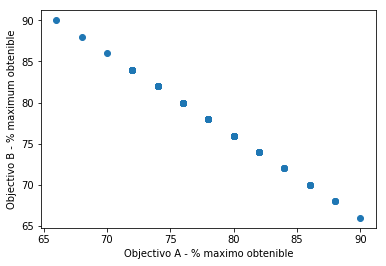

In [14]:
## Plotea los individuos de la frontera de Pareto final
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0].fitness)
    
# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

x = fitnesses[:, 0]/CHROMOSOME_SIZE*100
y = fitnesses[:, 1]/CHROMOSOME_SIZE*100
plt.xlabel('Objectivo A - % maximo obtenible')
plt.ylabel('Objectivo B - % maximum obtenible')
plt.scatter(x,y)
#plt.savefig('pareto.png')
plt.show()
